In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

So far we have compared, in parralel, the V4 and CNN units to the APC model. Now we are interested in whether the CNN units and V4 have any direct relationship. Of special interest is whether the CNN can predict responses of V4 that the APC model cannot.

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  1 12:08:05 2016

@author: deanpospisil
"""
import matplotlib.pyplot as plt 
import numpy as np
import os, sys
top_dir = os.getcwd().split('ipython_nb')[0]
sys.path.append(top_dir+ 'v4cnn/')
sys.path.append( top_dir + 'xarray');top_dir = top_dir + 'v4cnn/';
sys.path.append( top_dir + 'common/')
sys.path.append(top_dir +'/nets')
import xarray as xr;import pandas as pd
import apc_model_fit as ac
import matplotlib.cm as cm
import scipy.io as  l
%matplotlib inline   
import d_curve as dc
import d_img_process as imp
import caffe_net_response as cf 

def vis_square(ax, data, padsize=0, padval=0):
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    ax.set_xticks([]);ax.set_yticks([])
#    if min((data.ravel())>=0):
#        clim = (min(abs(data.ravel())), max(abs(data.ravel())))
#    else:
#        clim = (-max(abs(data.ravel())), max(abs(data.ravel())))

    im = ax.imshow(data, interpolation='nearest', cmap=cm.coolwarm)
    #cbar=ax.colorbar(shrink=0.8)
    #cbar.ax.set_ylabel('Response', rotation= 270, labelpad=15, fontsize = 15,)
#    cbar.ax.yaxis.set_ticks([0,.25,.5,.75, 1])
#    cbar.ax.set_yticklabels(['0', .25, .5, .75, 1])
    #cbar.solids.set_rasterized(True)
    return im
    
def plot_resp_on_shapes(ax, imgStack, resp, image_square = 19):
    resp_sc = resp
    imgStack = imgStack*resp_sc.reshape(362,1,1)
    #sort images
    sortStack = imgStack[list(reversed(np.argsort(resp_sc))),:,:]
    sortStack = np.array([imp.centeredCrop(img, 64, 64) for img in sortStack])
    im = vis_square(ax, sortStack[0:image_square**2])
    return im
def beautify(ax=None, spines_to_remove = ['top', 'right']):
    almost_black = '#262626'
    more_grey = '#929292'
#    text_font = 'serif'
#    number_font = 'helvetica'
    all_spines = ['bottom','left','right','top']
    # Get the axes.
    if ax is None:
        #fig = plt.figure(1)
        ax = plt.axes()
    if not type(ax)==type([]):
        ax = [ax,]
    for a_ax in ax:
        # Remove 'spines' (axis lines)
        for spine in spines_to_remove:
            a_ax.spines[spine].set_visible(False)
    
        # Make ticks only where there are spines
        if 'left' in spines_to_remove:
            a_ax.tick_params(left=0)
        if 'right'  in spines_to_remove:
            a_ax.tick_params(right=0)
        if 'bottom'  in spines_to_remove:
            a_ax.tick_params(bottom=0)
        if 'top'  in spines_to_remove:
            a_ax.tick_params(top=0)
    
        # Now make them go 'out' rather than 'in'
        for axis in ['x', 'y']:
            a_ax.tick_params(axis=axis, which='both', direction='out', pad=7)
            a_ax.tick_params(axis=axis, which='major', color=almost_black, length=6)
            a_ax.tick_params(axis=axis, which='minor', color=more_grey, length=4)
    
        # Make thinner and off-black
        spines_to_keep = list(set(all_spines) - set(spines_to_remove))
        
        for spine in spines_to_keep:
            a_ax.spines[spine].set_linewidth(0.5)
            a_ax.spines[spine].set_color(almost_black)

    
        # Change the labels & title to the off-black and change their font
        for label in [a_ax.yaxis.label, a_ax.xaxis.label, a_ax.title]:
            label.set_color(almost_black)
    
        # Change the tick labels' color and font and padding
        for axis in [a_ax.yaxis, a_ax.xaxis]:
            # padding
            axis.labelpad = 20
            # major ticks
            for major_tick in axis.get_major_ticks():
                label = major_tick.label
                label.set_color(almost_black)
            # minor ticks
            for minor_tick in axis.get_minor_ticks():
                label = minor_tick.label
                label.set_color(more_grey)

    #plt.grid(axis='y', color=more_grey)
def scatter_lsq(ax, a, b, lsq=True, mean_subtract=True, **kw):    

    if len(a.shape)<=1:
        a = np.expand_dims(a,1)
    if len(b.shape)<=1:
        b = np.expand_dims(b,1)
    
    if mean_subtract:
        a -= np.mean(a);b -= np.mean(b)
    if a.shape[1] > 1 :
        print('a second dim to big, just taking the first col')
        a = a[:,1]
    if b.shape[1] > 1 :
        print('b second dim to big, just taking the first col')
        b = b[:,1]   
    if lsq:
        x = np.linalg.lstsq(a, b)[0]
        a_scaled = np.dot(a, x)
    else:
        a_scaled = a
    ax.scatter(a_scaled, b, **kw)
    return a_scaled, b
    
    
def boot_strap_se(a, bstraps=1000):
    stats = []
    for ind in range(bstraps):
        resample = np.random.randint(0, high=np.shape(a)[0], size=np.shape(a)[::-1])
        stats.append([np.mean(a[col, i]) for i, col in enumerate(resample)])
    return np.percentile(np.array(stats), [1,99], axis=0)
def cor2(a,b):
    if len(a.shape)<=1:
        a = np.expand_dims(a,1)
    if len(b.shape)<=1:
        b = np.expand_dims(b,1)
    a -= a.mean(0);b-=b.mean(0)
    a /= np.linalg.norm(a, axis=0);b /= np.linalg.norm(b, axis=0);
    corrcoef = np.dot(a.T, b)       
    return corrcoef

In [3]:
#%%
#shape image set up
img_n_pix = 227
max_pix_width = [64,]
s = l.loadmat(top_dir + 'img_gen/PC3702001ShapeVerts.mat')['shapes'][0]
base_stack = dc.center_boundary(s)
boundaries = imp.center_boundary(s)
scale = max_pix_width/dc.biggest_x_y_diff(boundaries)
shape_ids = range(-1, 370); center_image = round(img_n_pix/2)
x = (center_image, center_image, 1);
y = (center_image, center_image, 1)
stim_trans_cart_dict, _ = cf.stim_trans_generator(shapes=shape_ids, scale=scale, 
                                                  x=x, y=y)
#plt.figure(figsize=(12,24));
center = 114
trans_img_stack = np.array(imp.boundary_stack_transform(stim_trans_cart_dict, 
                                                        base_stack, 
                                                        npixels=227))
no_blank_image = trans_img_stack[1:]
a = np.hstack((range(14), range(18, 318)));a = np.hstack((a, range(322, 370)))
no_blank_image = no_blank_image[a]/255.

In [4]:
#%%   
#v4 fit to CNN and APC
v4_name = 'V4_362PC2001'
v4_resp_apc = xr.open_dataset(top_dir + 'data/responses/' + v4_name + '.nc')['resp'].load()
v4_resp_apc = v4_resp_apc.transpose('shapes', 'unit')
file = open(top_dir + 'data/responses/v4_apc_109_neural_labels.txt', 'r')
wyeth_labels = [label.split(' ')[-1] for label in 
            file.read().split('\n') if len(label)>0]
v4_resp_apc['w_lab'] = ('unit', wyeth_labels)

clusters = {}
clusters['apc_red'] =  [1,12,24,33,38,43,58,87,91,109];  
clusters['brown'] = [68, 70, 71, 72, 79];
clusters['area_blue'] =  [17, 40, 59, 64, 77, 78, 82, 85, 102]
clusters['green'] =  [27, 53, 56, 65];
clusters['purple'] = [36, 83, 92];
clusters['grey']  = [37,51,61,63];
cluster_index = [[] for x in range(109)]
for a_cluster in clusters:
    for ind in clusters[a_cluster]:
        cluster_index[ind-1] = a_cluster
for i, a_entry in enumerate(cluster_index):
    if len(a_entry) == 0:
        cluster_index[i] = 'none'
v4_resp_apc['cluster'] = ('unit', cluster_index)


fn = top_dir + 'data/models/' + 'apc_models_362.nc'

if 'apc_fit_v4' not in locals():
    dmod = xr.open_dataset(fn, chunks={'models':50, 'shapes':370})['resp'].load()
    apc_fit_v4 = ac.cor_resp_to_model(v4_resp_apc.chunk({'shapes': 370}), 
                                      dmod.chunk({}), 
                                      fit_over_dims=None, 
                                      prov_commit=False)**2

cnn_names =['bvlc_reference_caffenetAPC362_pix_width[32.0]_pos_(64.0, 164.0, 51)',
            'blvc_caffenet_iter_1APC362_pix_width[32.0]_pos_(64.0, 164.0, 51)']
colors = ['r','g','b','m','c', 'k', '0.5']
from sklearn.model_selection import ShuffleSplit
X = np.arange(362)
cv_scores = []
model_ind_lists = []
models = []
for cnn_name in cnn_names:
    da = xr.open_dataset(top_dir + 'data/responses/' + cnn_name + '.nc')['resp']
    da = da.sel(unit=slice(0, None, 1)).squeeze()
    middle = np.round(len(da.coords['x'])/2.).astype(int)
    da_0 = da.sel(x=da.coords['x'][middle])
    da_0 = da_0.sel(shapes=v4_resp_apc.coords['shapes'].values)
    models.append(da_0)
models.append(dmod)
print(v4_resp_apc)

<xarray.DataArray 'resp' (shapes: 362, unit: 109)>
array([[ 0.1   ,  0.1304,  0.0875, ...,  0.4   ,  0.1957,  0.    ],
       [ 0.    ,  0.1957,  0.5   , ...,  0.5   ,  0.9348,  0.    ],
       [ 0.    ,  0.1087,  0.2625, ...,  0.1667,  0.3043,  0.0333],
       ..., 
       [ 0.    ,  0.2609,  0.1375, ...,  0.    ,  0.3043,  0.3111],
       [ 0.125 ,  0.2826,  0.325 , ...,  0.    ,  0.087 ,  0.1333],
       [ 0.275 ,  0.2174,  0.175 , ...,  0.1   ,  0.2826,  0.4444]])
Coordinates:
  * shapes   (shapes) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 18 19 20 21 22 ...
  * unit     (unit) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    w_lab    (unit) <U5 'a1301' 'a1401' 'a1501' 'a1502' 'a1701' 'a1801' ...
    cluster  (unit) <U9 'apc_red' 'none' 'none' 'none' 'none' 'none' 'none' ...


In [5]:
#cross_val fit of V4 to CNN trained, untrained and APC
n_splits = 50
for model in models:
    ss = ShuffleSplit(n_splits=n_splits, test_size=1/5,
        random_state=0)
    cv_score = []
    model_ind_list = []
    for train_index, test_index in ss.split(X):
        cor_v4_model = cor2(model.values[train_index], 
                               v4_resp_apc.values[train_index])
        cor_v4_model[np.isnan(cor_v4_model)] = 0
        model_sel = cor_v4_model.argmax(0)
        cor_v4_model_cv = np.array([cor2(v4_resp_apc[test_index, i], 
                            model[test_index, model_ind])
                            for i, model_ind in enumerate(model_sel)]).squeeze()
        model_ind_list.append(model_sel)
        cor_v4_model_cv[np.isnan(cor_v4_model_cv)] = 0
        cv_score.append(cor_v4_model_cv)
    cv_scores.append(cv_score)
    model_ind_lists.append(model_ind_list)
model_ind_lists_cv = np.array(model_ind_lists)
cor_v4_models_cv = np.array(cv_scores)

In [106]:
#%%
#direct fit of V4 to CNN trained, untrained and APC
model_ind_lists = []
cor_v4_models = []
all_model_cor = []
for model in models:
    cor_v4_model = cor2(model.values, v4_resp_apc.values)
    cor_v4_model[np.isnan(cor_v4_model)] = 0
    all_model_cor.append(cor_v4_model)
    model_sel = cor_v4_model.argmax(0)
    model_cor = cor_v4_model.max(0)
    cor_v4_models.append(model_cor)
    model_ind_lists.append(model_sel)

model_ind_lists_dirfit = np.array(model_ind_lists)
cor_v4_models_dirfit = np.array(cor_v4_models)

With the direct fit we can actually look up the model that it fit to. One thing we can be concerned with, is how special the fit was. Was there another unit in the network that could have fit just as well. And if there was another that could have was it from a similar or different layer? 

63
[20990   901 21514 20514    16   112  1262  1006  7860  3764]
[ 0.66662097  0.66662097  0.66663871  0.66667182  0.66718751  0.66718751
  0.66729718  0.66729718  0.66893115  0.66893115  0.67106015  0.67136176
  0.67136176  0.67161105  0.67161105  0.67181055  0.67324905  0.67424405
  0.67424405  0.67486964  0.67486964  0.67711181  0.67711181  0.67752821
  0.67814988  0.67814988  0.6794152   0.6794152   0.68351591  0.68417814
  0.68543186  0.68568566  0.68626575  0.68677564  0.70406182  0.70689762
  0.7086584   0.70883216  0.71028669  0.71028669]
a9501
area_blue
[b'fc8' b'pool2' b'prob' b'fc8' b'conv1' b'relu1' b'norm2' b'pool2'
 b'relu6' b'fc6']


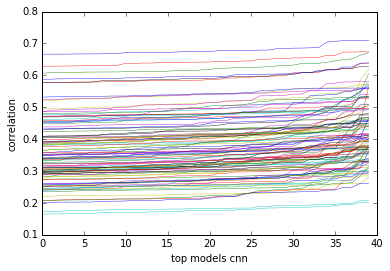

In [130]:
model_ind = 1
print(cor_v4_models_dirfit[model_ind].argmax())
print(np.argsort(all_model_cor[model_ind][:,63])[-10:])

for ind in range(109):
    plt.plot(np.sort(all_model_cor[model_ind][:,ind])[-40:],lw=0.4)
plt.xlabel('top models cnn')
plt.ylabel('correlation')
print(np.sort(all_model_cor[model_ind][:,63])[-40:])
print(v4_resp_apc[:, 63].coords['w_lab'].values)
print(v4_resp_apc[:, 63].coords['cluster'].values)
print(models[model_ind].coords['layer_label'].values[np.argsort(all_model_cor[model_ind][:, 63])[-10:]])

It would seem there is sometimes a big jump, and sometimes not. The best fit unit by the CNN was an area cell and it is also well fit by many other cells.

One of the first things we should consider is the flexibility of the APC model and the CNN. The APC model is found by a brute force search over ~60,000 vectors but the true APC model has four parameters thus this search process probably has ~4 df. The CNN fit is a brute force search over ~20,000 vectors and it is unknown how many degrees of freedom underly this fitting. Comparing fits of the two is blurred by a potential difference in df as the CNN might do better simply because it is more flexible. One way around this is to perform cross validation, testing on a hold out set of data. Lets compare the cross-validated approach to a direct fit.

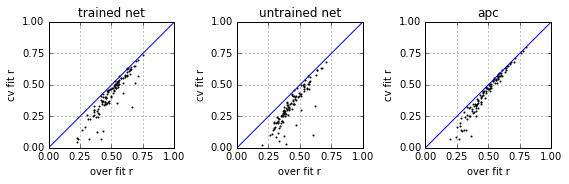

In [8]:
#%%
#cross val vs line fit
plt.figure(figsize=(8,16))
titles = ['trained net', 'untrained net', 'apc']
for i, (dirfit, cv) in enumerate(zip(cor_v4_models_dirfit, cor_v4_models_cv)):
    ax = plt.subplot(1,3,i+1)
    ax.scatter(dirfit, cv.mean(0),s=1);ax.set_title(titles[i]);
    ax.set_xlabel('over fit r');ax.set_ylabel('cv fit r');
    ax.plot([0,1],[0,1])
    ax.set_yticks([0,0.25,.5,.75,1])
    ax.set_xticks([0,0.25,.5,.75,1])
    ax.set_xlim(0,1);ax.set_ylim(0,1);
    plt.gca().set_aspect('equal', 'box-forced')
    ax.grid()

plt.tight_layout() 

How flexible each fitting procedure is, is indexed by how much better a fit is for the over fit (when we fit directly and measure score) vs cv fit where the score is an average of hold out sets of data. By this criteria it would seem the net fitting is more flexible than APC.

Most of the plots have a downward curve suggesting the over fit procedure tends to do better when the models stop being able to predict the hold out set. Presumably when there is a strong correlation over the whole response it is more likely for each of the test sets to also be well correlated (as long as the responses driving the correlation are distributed evenly across the response).

What difference do these results make? Lets compare a scatter of APC vs CNN fits to V4 data using cross-validated and direct fits.

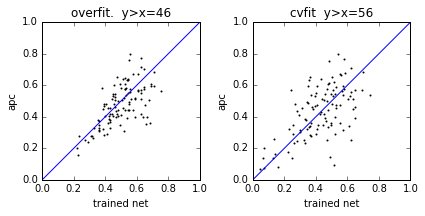

In [9]:
plt.figure()
ax = plt.subplot(121)
ax.scatter(cor_v4_models_dirfit[0], cor_v4_models_dirfit[2], s=1)
y_greater_x = np.sum(cor_v4_models_dirfit[2]>cor_v4_models_dirfit[0])

ax.set_title('overfit.  y>x='+ str(y_greater_x));

ax.set_xlabel('trained net');ax.set_ylabel('apc');
plt.gca().set_aspect('equal', 'box-forced')
ax.set_xlim(0,1);ax.set_ylim(0,1);
ax.plot([0,1],[0,1])

ax = plt.subplot(122)
ax.scatter(cor_v4_models_cv[0].mean(0), cor_v4_models_cv[2].mean(0), s=1)
y_greater_x = np.sum(cor_v4_models_cv[2].mean(0)>cor_v4_models_cv[0].mean(0))
ax.set_title('cvfit  y>x='+ str(y_greater_x));
ax.set_xlabel('trained net');ax.set_ylabel('apc');
plt.gca().set_aspect('equal', 'box-forced')
ax.set_xlim(0,1);ax.set_ylim(0,1);
ax.plot([0,1],[0,1])
plt.tight_layout() 

In both cases we see a fair amount of deviation from the line of unity suggesting sometimes APC does better other times the CNN. We see that in the case of overfitting the CNN tends to do better with 46/109 V4 cells being better fit to APC but then this evens out with cross validation with 56/109 V4 cells better fit to APC about even.

This is more extreme in the case of cross validated data. One explanation is that summing each test set score there is correlation between these samples adding more variance? 

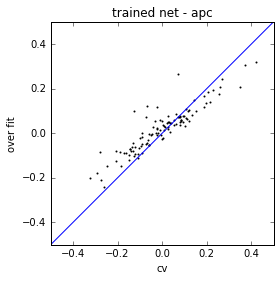

In [10]:
plt.figure()
ax = plt.subplot(111)

ax.scatter(cor_v4_models_cv[0].mean(0)-cor_v4_models_cv[2].mean(0),
           cor_v4_models_dirfit[0]-cor_v4_models_dirfit[2], s=1)

ax.set_title('trained net - apc');
ax.set_xlabel('cv');ax.set_ylabel('over fit');
plt.gca().set_aspect('equal', 'box-forced')
ax.set_xlim(-0.5,0.5);ax.set_ylim(-0.5,0.5);
ax.plot([-1,1],[-1,1])

The difference between the trained net and the apc model are largely maintained when over fitting vs cross validation. Over fitting does tend to have a tighter distribution. From experience the big jumps between the two come from more sparse responses in the net, it captures just a few shapes, but as soon as you start resampling, this goes away.

In [11]:
#%%
cv_scores = np.array(cv_scores)
mean_scores = cv_scores.mean(1)
#bsci_scores= np.array([boot_strap_se(cv_score) for cv_score in cv_scores])
bsci_scores= np.array([np.percentile(np.array(cv_score), [5,95], axis=0) for cv_score in cv_scores])
bsci_scores = bsci_scores - np.expand_dims(mean_scores,1)

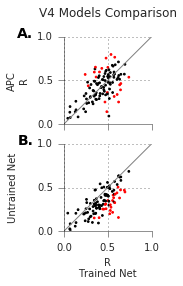

In [12]:
#%%
ax_list=[]
plt.figure(figsize=(4,4))
ax = plt.subplot(221)
ax_list.append(ax)
ax.locator_params(nbins=5)
ax.set_title('V4 Models Comparison\n')
x = mean_scores[0]
y = mean_scores[2]
xsd = bsci_scores[0]
ysd = bsci_scores[2]
ax.errorbar(x, y, yerr=np.abs(ysd), xerr=np.abs(xsd), fmt='o', 
            alpha=0, markersize=0, color='r', ecolor='0.5')
colors= np.array(['k',]*len(x))
colors[((np.abs(x-y)-np.max(np.abs(ysd),0))>0) & 
       ((np.abs(x-y)-np.max(np.abs(xsd),0))>0)] = 'r'
ax.scatter(x,y, color=colors, s=3)
#ax.scatter(x, y, alpha=0.5, s=2)
ax.plot([0,1],[0,1], color='0.5')
#ax.set_xlabel('Trained Net')
ax.set_ylabel('APC\nR',labelpad=0)
ax.yaxis.set_label_coords(-0.4, 0.5)

ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.set_xticks([0,0.5,1])
ax.set_xticklabels([])
ax.set_yticks([0, 0.5, 1])
plt.grid()
beautify(ax)

ax = plt.subplot(223)
ax_list.append(ax)

ax.locator_params(nbins=5)
x = mean_scores[0]
y = mean_scores[1]
xsd = bsci_scores[0]
ysd = bsci_scores[1]

#ax.scatter(x, y, alpha=0.5, s=2)
ax.errorbar(x, y, yerr=np.abs(ysd), xerr=np.abs(xsd), fmt='o', 
            alpha=0, markersize=0, color='r', ecolor='0.5')
colors= np.array(['k',]*len(x))
colors[((np.abs(x-y)-np.max(np.abs(ysd),0))>0) & 
       ((np.abs(x-y)-np.max(np.abs(xsd),0))>0)] = 'r'
ax.scatter(x,y, color=colors, s=3)
ax.plot([0,1],[0,1], color='0.5')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
beautify(ax)

ax.set_xlabel('R\nTrained Net',labelpad=5)
ax.set_ylabel('Untrained Net', labelpad=12)
ax.yaxis.set_label_coords(-0.52, 0.5)

plt.grid()
labels = ['A.', 'B.']
for ax, label in zip(ax_list, labels):
    ax.text(-0.35, 1.12, label, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()

plt.savefig(top_dir + '/analysis/figures/images/v4cnn_cur/fig3_apc_vs_cnn.pdf')

/Users/deanpospisil/Desktop/modules/v4cnn/common/d_img_process.py:163: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cImg = img[top:bottom, left:right]


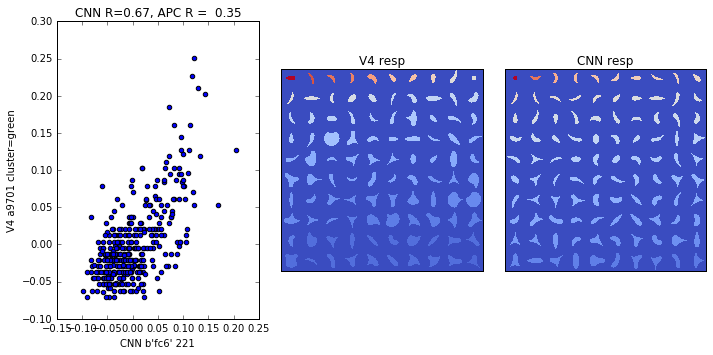

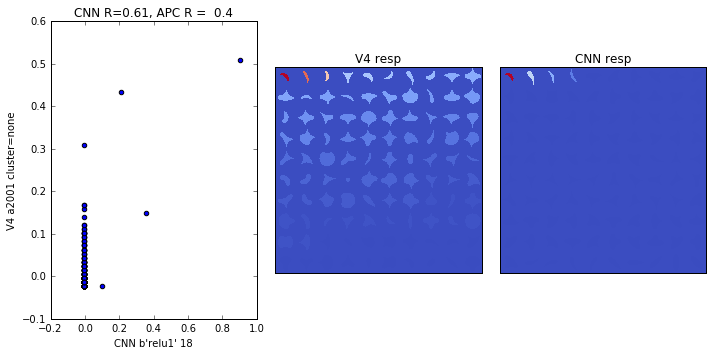

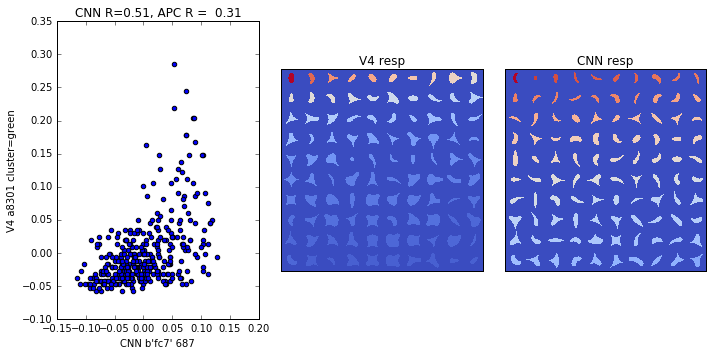

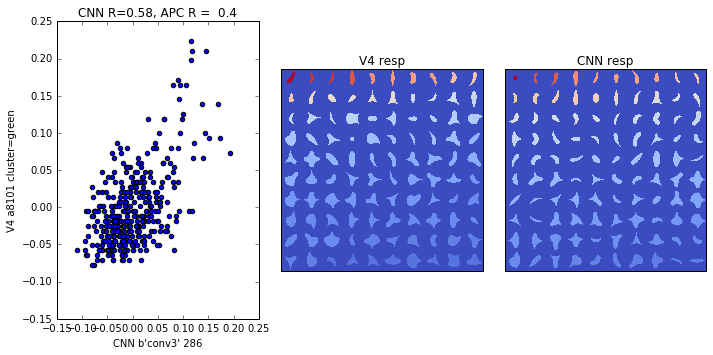

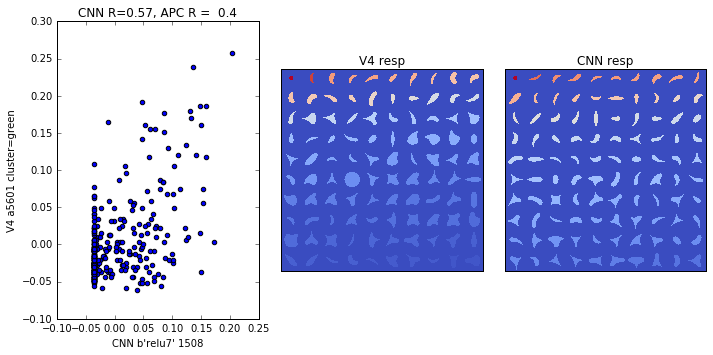

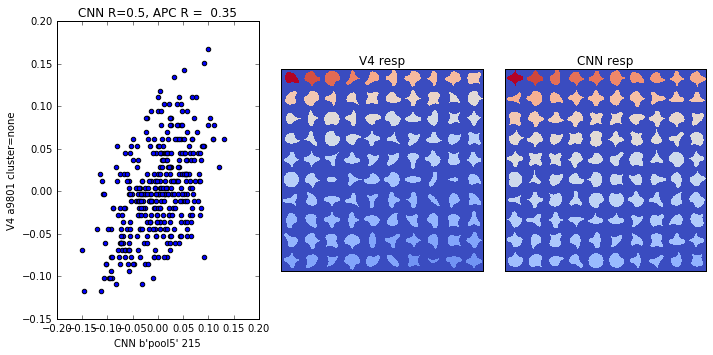

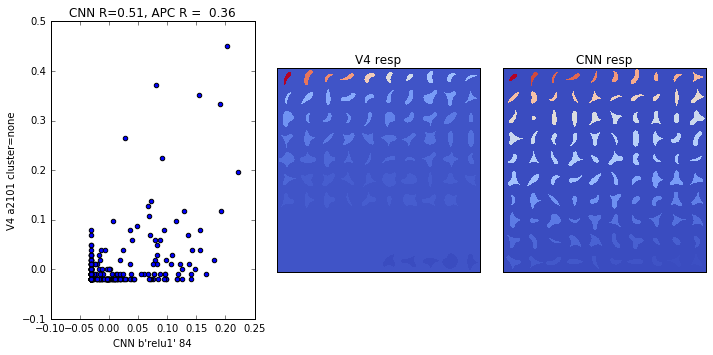

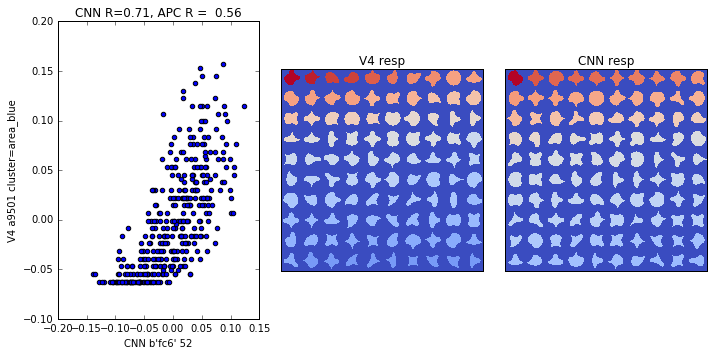

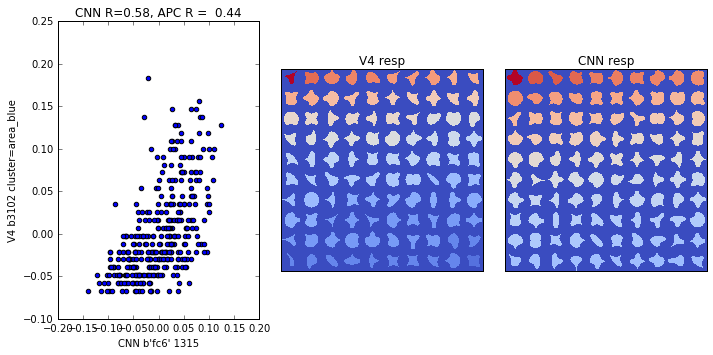

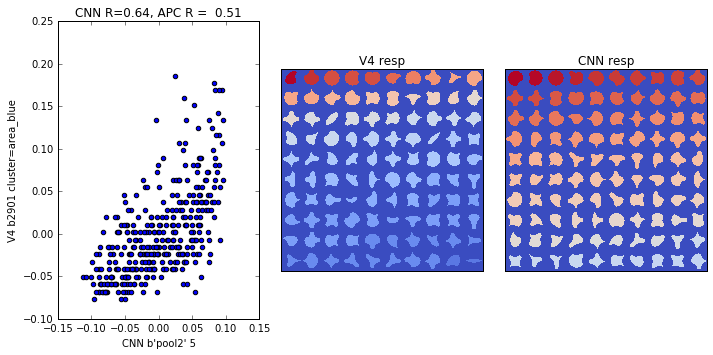

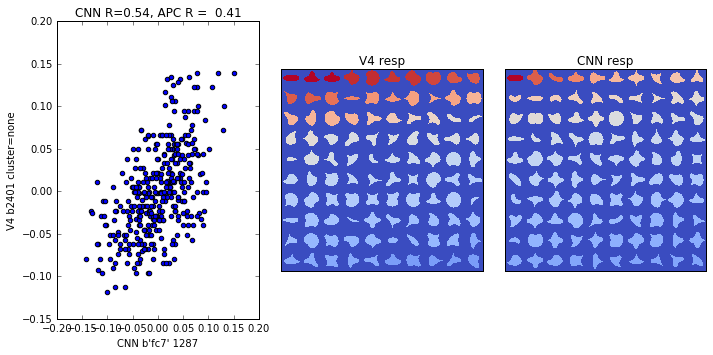

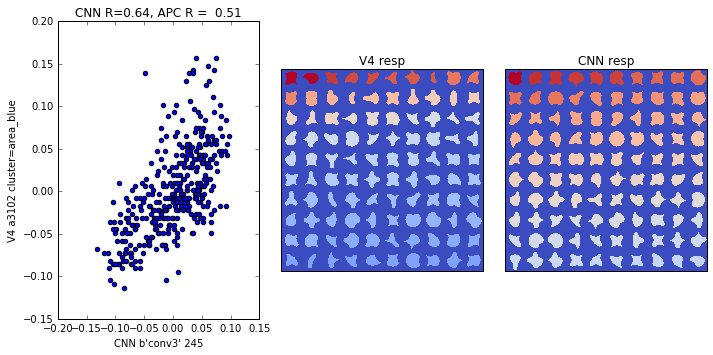

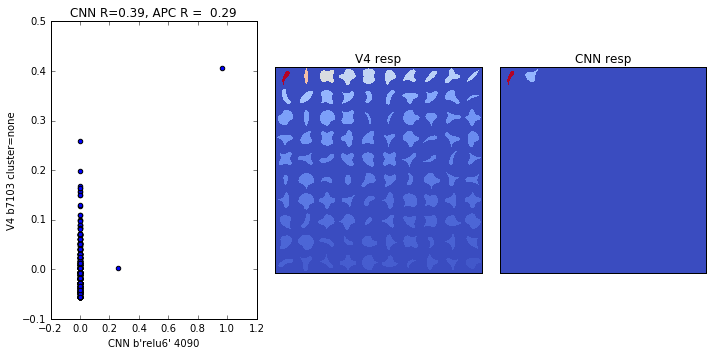

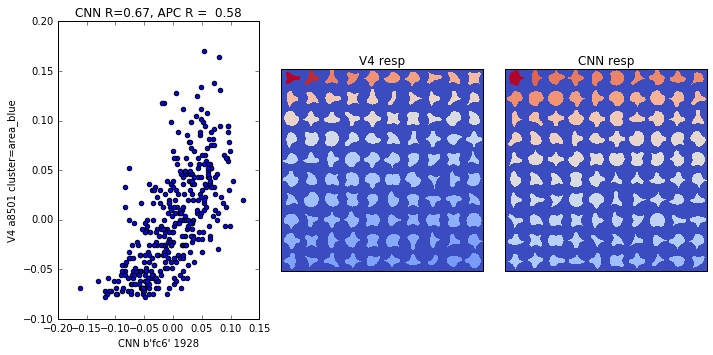

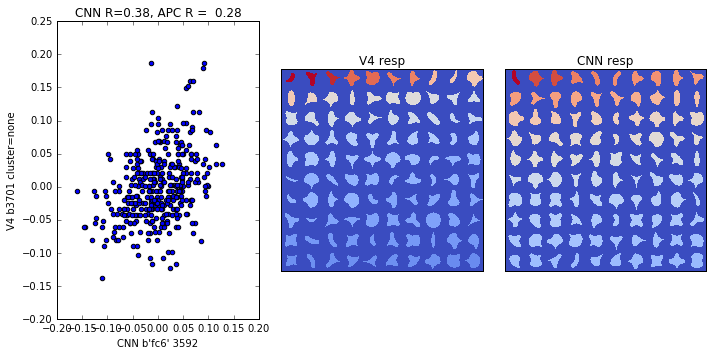

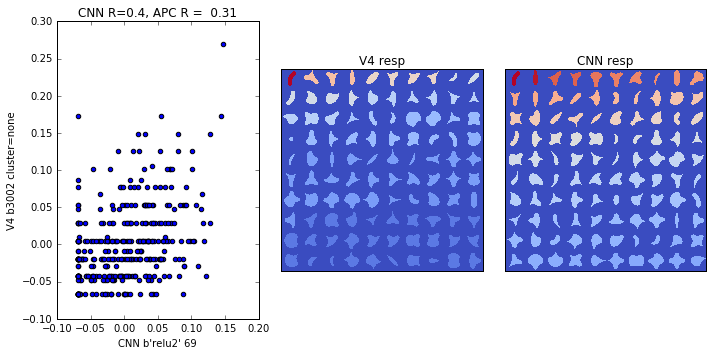

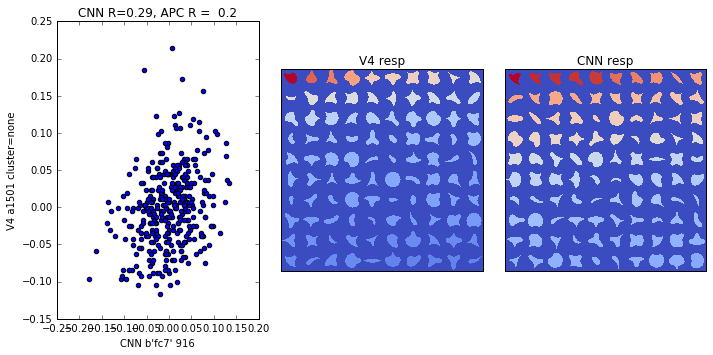

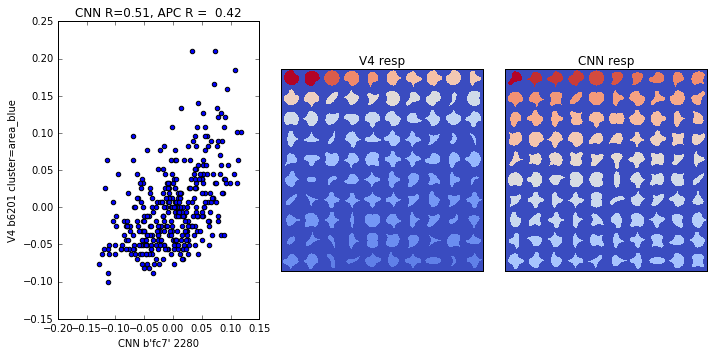

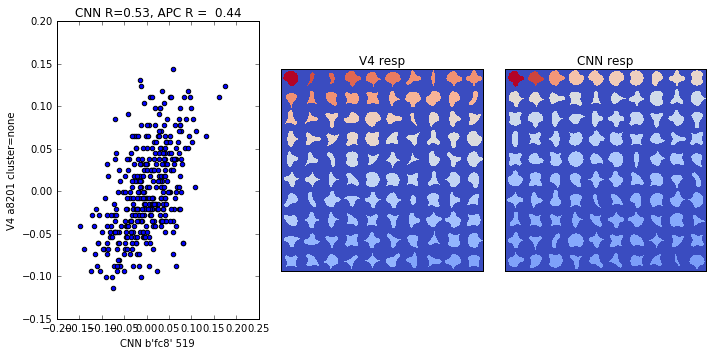

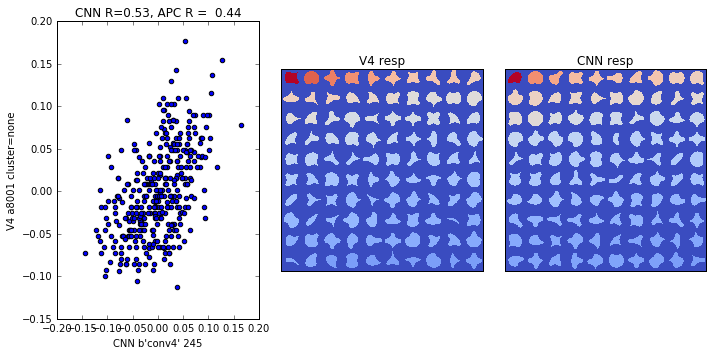

In [20]:
sel_models = []
for model, model_sel in zip(models, model_ind_lists_dirfit):
    sel_models.append(model[:, model_sel])

model_ind = 0    
cnn_does_better = np.argsort(cor_v4_models_dirfit[model_ind]-cor_v4_models_dirfit[2])[::-1]
sel_models[model_ind][:, int(i)]
for i in cnn_does_better[:20]:
    plt.figure(figsize=(10,5))
    ax = plt.subplot(131)
    #plt.gca().set_aspect('equal', 'box-forced')
    ax.scatter(sel_models[model_ind][:, int(i)], v4_resp_apc[:, int(i)])
    ax.set_xlabel('CNN ' + str(sel_models[model_ind][:, int(i)].coords['layer_label'].values) + ' ' 
                               + str(sel_models[model_ind][:, int(i)].coords['layer_unit'].values));
    ax.set_ylabel('V4 ' + str(v4_resp_apc[:, int(i)].coords['w_lab'].values)
                 + ' cluster=' + str(v4_resp_apc[:, int(i)].coords['cluster'].values));
    ax.set_title('CNN R=' + str(np.round(cor_v4_models_dirfit[model_ind, i],2)) + ', APC R =  ' + str(np.round(cor_v4_models_dirfit[2, i],2)) );
    
    ax = plt.subplot(132)
    plot_resp_on_shapes(ax, no_blank_image, v4_resp_apc[:, int(i)].values, image_square=10)
    ax.set_title('V4 resp')
    
    ax = plt.subplot(133)
    plot_resp_on_shapes(ax, no_blank_image, sel_models[model_ind][:, int(i)].values, image_square=10)
    ax.set_title('CNN resp')
    plt.tight_layout()

There is quite a diversity of relationships. Some of these are driven by sparsity and overfitting, or at least the relationship isn't spread over many shapes. 

Interestingly some of the ones the APC model didn't do as well on were clustered by Reza, the area cells are a good example.

Another interesting example is the green cluster which is accounted for by pretty early layers. 

More than half (11/20) fall into clusters and some that don't are being predicted by highly sparse responses. Only 32% of the V4 cells were placed into clusters.  I'd have to think a little more about this but this seems unlikely by chance, though perhaps has something to do with SNR. We might want to check the relationship between SNR and fit to either model.

a2101
Bean neurons

a9701 in green group
scrawny shapes

In [14]:
from collections import Counter
Counter(cluster_index)

Counter({'apc_red': 10,
         'area_blue': 9,
         'brown': 5,
         'green': 4,
         'grey': 4,
         'none': 74,
         'purple': 3})

In [15]:
35/109

0.3211009174311927

In [16]:
v4_resp_trials = xr.open_dataset(top_dir + 'data/responses/apc_orig/apc370_with_trials.nc')

In [17]:
print(v4_resp_trials['resp'])

<xarray.DataArray 'resp' (unit: 109, shapes: 371, trials: 25)>
[1010975 values with dtype=float64]
Coordinates:
    w_lab    (unit) |S7 b'a1301_2' b'a1401' b'a1501' b'a1502' b'a1701' ...
  * shapes   (shapes) int32 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * trials   (trials) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * unit     (unit) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes:
    fs: 1000.0
    start: -150.0
    dur: 850.0


In [18]:
v4_resp_mean = xr.open_dataset(top_dir + 'data/responses/V4_362PC2001.nc')['resp'].load()
v4_resp_trials = xr.open_dataset(top_dir + 'data/responses/apc_orig/apc370_with_trials.nc')
v4_resp_trials = v4_resp_trials['resp'].load().transpose('shapes','unit','trials')
v4_resp_trials = v4_resp_trials.loc[v4_resp_mean.coords['shapes'].values, :, :]

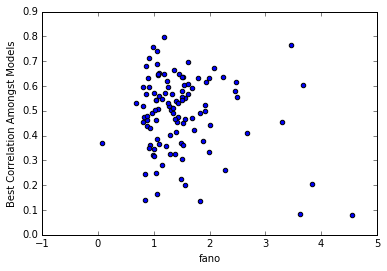

In [124]:
fano=v4_resp_trials.var('trials').sum('shapes')/v4_resp_trials.mean('trials').sum('shapes')
fitness = cor_v4_models_cv.mean(1).squeeze().max(0)
#fitness = cor_v4_models_dirfit.max(0)

plt.scatter(fano, fitness);
plt.xlabel('fano')
plt.ylabel('Best Correlation Amongst Models')

No clear trends here. The best fit cells have the same variability of some of the worst. There are examples of super poisson cells that are really well fit.

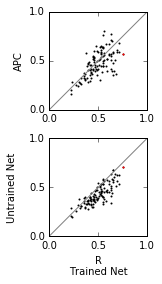

In [62]:
plt.figure(figsize=(4,4))
ind = cor_v4_models_dirfit[1].argsort()[-1]

ax = plt.subplot(212)
ax.scatter(cor_v4_models_dirfit[0], cor_v4_models_dirfit[1],s=1)
ax.scatter(cor_v4_models_dirfit[0,ind], cor_v4_models_dirfit[1,ind],s=1, color='r')

ax.plot([0,1],[0,1], color='0.5')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
plt.gca().set_aspect('equal', 'box-forced')

ax.set_xlabel('R\nTrained Net',labelpad=5)
ax.set_ylabel('Untrained Net', labelpad=12)

ax = plt.subplot(211)
ax.scatter(cor_v4_models_dirfit[0], cor_v4_models_dirfit[2],s=1)
ax.plot([0,1],[0,1], color='0.5')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
plt.gca().set_aspect('equal', 'box-forced')
ax.set_ylabel('APC')
ax.scatter(cor_v4_models_dirfit[0,ind], cor_v4_models_dirfit[2,ind],s=1, color='r')

plt.tight_layout()

/Users/deanpospisil/Desktop/modules/v4cnn/common/d_img_process.py:163: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cImg = img[top:bottom, left:right]


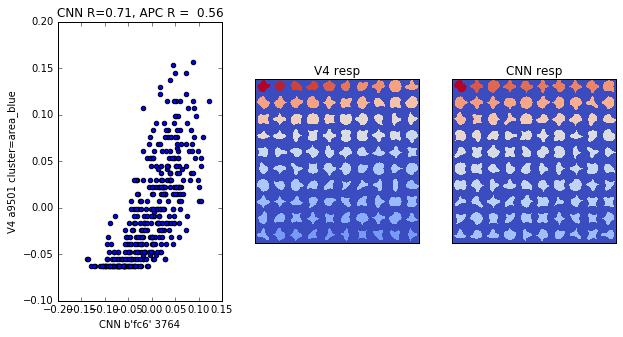

In [126]:
sel_models = []
for model, model_sel in zip(models, model_ind_lists_dirfit):
    sel_models.append(model[:, model_sel])

model_ind = 1
cnn_best = np.argsort(cor_v4_models_dirfit[model_ind])[::-1]
sel_models[model_ind][:, int(i)]
for i in cnn_best[:1]:
    plt.figure(figsize=(10,5))
    ax = plt.subplot(131)
    #plt.gca().set_aspect('equal', 'box-forced')
    ax.scatter(sel_models[model_ind][:, int(i)], v4_resp_apc[:, int(i)])
    ax.set_xlabel('CNN ' + str(sel_models[model_ind][:, int(i)].coords['layer_label'].values) + ' ' 
                               + str(sel_models[model_ind][:, int(i)].coords['unit'].values));
    ax.set_ylabel('V4 ' + str(v4_resp_apc[:, int(i)].coords['w_lab'].values)
                 + ' cluster=' + str(v4_resp_apc[:, int(i)].coords['cluster'].values));
    ax.set_title('CNN R=' + str(np.round(cor_v4_models_dirfit[model_ind, i],2)) + ', APC R =  ' + str(np.round(cor_v4_models_dirfit[2, i], 2)) );
    
    ax = plt.subplot(132)
    plot_resp_on_shapes(ax, no_blank_image, v4_resp_apc[:, int(i)].values, image_square=10)
    ax.set_title('V4 resp')
    
    ax = plt.subplot(133)
    plot_resp_on_shapes(ax, no_blank_image, sel_models[model_ind][:, int(i)].values, image_square=10)
    ax.set_title('CNN resp')
    plt.tight_layout
                  

In [44]:
sel_models[1]


<xarray.DataArray 'resp' (shapes: 362, unit: 109)>
array([[ 0.02526277, -0.11428183, -0.06681377, ...,  0.54032087,
        -0.09671935, -0.05690955],
       [-0.01716047,  0.07440453, -0.04701044, ..., -0.00519058,
         0.13005903, -0.06027972],
       [ 0.07993857, -0.08663926, -0.06814257, ..., -0.00519058,
        -0.02069841,  0.06655663],
       ..., 
       [-0.01921907,  0.04906403,  0.01190128, ..., -0.00519058,
        -0.04476099, -0.02573521],
       [-0.09053304,  0.05176915,  0.00457991, ..., -0.00519058,
         0.05821811, -0.06529339],
       [ 0.01035833,  0.02433706, -0.033974  , ..., -0.00519058,
        -0.01341673,  0.07426086]], dtype=float32)
Coordinates:
    layer_unit   (unit) int32 1693 106 916 826 687 2381 53 1368 18 84 621 ...
    scale        float64 8.41
  * shapes       (shapes) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 18 19 20 21 ...
    layer_label  (unit) |S5 b'fc7' b'fc7' b'fc7' b'fc7' b'fc6' b'fc7' ...
    layer        (unit) float64 17.0 17.0 17.